In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import segyio
import itertools
import scipy.ndimage
import pandas as pd
from mayavi import mlab

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700


# 3.3 - reading in non-ideal datasets

In this section you will load the ST0202.segy dataset from the Volve field, North Sea. This dataset is not structured as nicely as TNW_small2 so you will need to do a bit more work to load it. 

- Now that our dataset is unstructure we do not have access anymore to the previously given dataset attributes, we can however work around this

- you will not be given an non-ideal dataset to process in the assessment, but we aware of the potential struggles of using non-ideal datasets if you download your own data from open source repositories. 


In [4]:
base_segy2 = '../data/ST0202.segy'
base_segy2 = segyio.open(base_segy2, ignore_geometry= True) 

Now that our dataset is unstructured we do not have access anymore to the automatically given dataset attributes, we can however work around this and fix our dataset

In [5]:
inlines = []
crosslines = []
for h in base_segy2.header:
    inlines.append(h[segyio.su.iline])
    crosslines.append(h[segyio.su.xline])

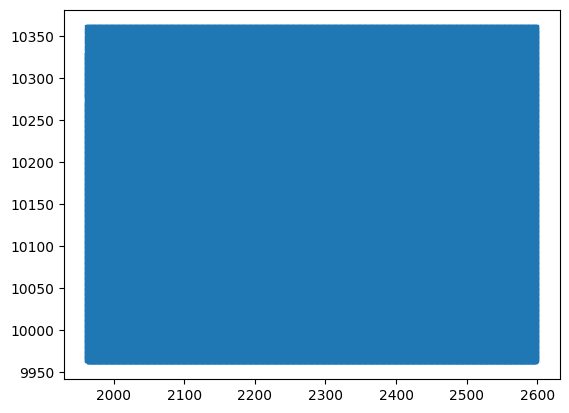

In [6]:
plt.scatter(crosslines, inlines, marker="s", s=1)

If you look very closely you can see there are travces missing in the left bottom and right bottom corner! 

Lets try to understand what is missing

In [7]:
uniqil = set(inlines)
uniqxl = set(crosslines)
real = set(zip(inlines, crosslines)) #set removes duplicates, works same as sets from maths
grid = set(itertools.product(uniqil, uniqxl))
missing = grid - real
print (missing)

{(10340, 1961), (10331, 1961), (9961, 1961), (10355, 1961), (10344, 1961), (10335, 1961), (9962, 2600), (9961, 2598), (9962, 1962), (10359, 1961), (10348, 1961), (10273, 1961), (10339, 1961), (10352, 1961), (10343, 1961), (10332, 1961), (9962, 1961), (10356, 1961), (9961, 2600), (10347, 1961), (9961, 1962), (10336, 1961), (9962, 2598), (10360, 1961), (10274, 1961), (10351, 1961)}


Lets fill out the missing traces and create a regular volume. 

In [8]:
ils = np.unique(inlines)
xls = np.unique(crosslines)
inline_interval    = ils[1:] - ils[:-1]
crossline_interval = xls[1:] - xls[:-1]


We now need to put every trace in the right place, which means we need to map in/crossline pairs to the right offset in our target array. Had no traces been missing, this is what segyio figures out by default.

In [9]:
ils = sorted(uniqil)
xls = sorted(uniqxl)
lineindex = {
    (il, xl): i
    for i, (il, xl) in enumerate(sorted(grid))

}

d = np.zeros((len(ils), len(xls), len(base_segy2.samples)))
lineard = d.reshape(d.shape[0] * d.shape[1], d.shape[2])
for il, xl, trace in zip(inlines, crosslines, base_segy2.trace[:]):
    lineard[lineindex[il, xl]][:] = trace[:]

In [10]:
def explore3d(data_cube, preset = True, I=-1, X = -1 , Z=-1):
    """
    
    """
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]
    vm = np.percentile(data_cube, 95) #may need to play a little with the 95
    
    if preset == True:
        nx, ny, nz = data_cube.shape
        I = nx//2
        X = ny//2
        Z = nz//2

    mlab.pipeline.image_plane_widget(source, plane_orientation='x_axes', 
                                     slice_index=I, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='y_axes', 
                                     slice_index=X, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.pipeline.image_plane_widget(source, plane_orientation='z_axes', 
                                     slice_index=Z, colormap='coolwarm', vmin=-vm, vmax=vm)
    mlab.show()

In [11]:
explore3d(d)


## 3.4 Data aliasing

The real world is continuous, however our hardware is limited in memory, time and accuracy so we need to compromise by discretising the world around. This is done through recording the signal at a constant time interval. In turn this data is then used to reconstruct the signal on a computer. 

The Nyquist theorem states that in order to to adequately reproduce a signal it should be periodically sampled at a rate that is 2x the highest frequency you wish to record. This is important when setting up an acquisition, because if you try to recover frequencies (resolutions) that do not satisfy the Nyquist theorem you will recover a wrong signal and have wrong data.

Lets write some code to visualise this:

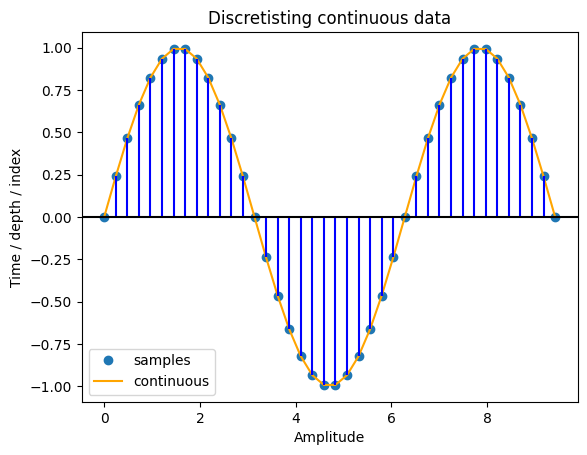

In [12]:
# data
data = np.linspace(0, 3*np.pi, 40)
sin = np.sin(data)
plt.plot(data, sin, 'o', label = 'samples')
plt.plot(data, sin, '-', label='continuous', color ='orange')

# vertical lines
sin_min = [i<=0 for i in sin]
ymin = sin_min * sin
sin_max = [i>=0 for i in sin]
ymax = sin_max * sin
plt.vlines(x=data, ymin=ymin, ymax=ymax, color='b')

# horizontal axis
plt.axhline(y=0, color='k')

plt.title('Discretisting continuous data')
plt.xlabel('Amplitude')
plt.ylabel('Time / depth / index')
plt.legend()
plt.show()

We can appreciate that we have plenty of data to be able to fit a correct curve to reproduce our original periodic signal. If this is the smallest frequency we are interested in being able to recover, we are wasting a lot of memory by sampling at a rate this high. If we are aware of the minimal frequency we want to be able to recover we can save on memory in the field by having the correct sampling rate.

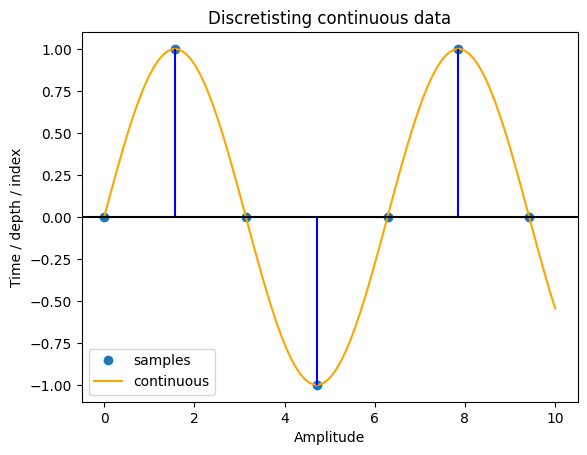

In [13]:
data = np.linspace(0, 3*np.pi, 7)
fill = np.linspace(0, 10, 100)
sin = np.sin(data)
sin_ = np.sin(fill)
plt.plot(data, sin, 'o', label = 'samples')
plt.plot(fill, sin_, '-',  label = 'continuous', color ='orange')

sin_min = [i<=0 for i in sin]
ymin = sin_min * sin
sin_max = [i>=0 for i in sin]
ymax = sin_max * sin

plt.vlines(x=data, ymin=ymin, ymax=ymax, color='b')
plt.axhline(y=0, color='k')
plt.title('Discretisting continuous data')
plt.xlabel('Amplitude')
plt.ylabel('Time / depth / index')
plt.legend()
plt.show()

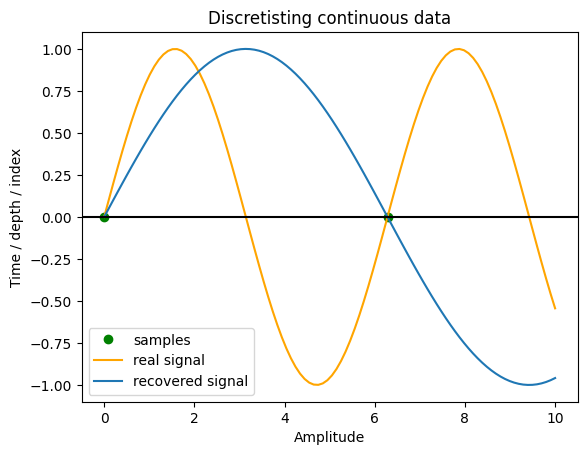

In [14]:
data = np.linspace(0, 2*np.pi, 2)
fill = np.linspace(0, 10, 100)
sin = np.sin(data)
sin_ = np.sin(fill)
sin_2 = np.sin(1/2*fill)
plt.plot(data, sin, 'o', label = 'samples',color = 'green')
plt.plot(fill, sin_, '-' , label = 'real signal', color ='orange')
plt.plot(fill, sin_2, '-', label = 'recovered signal')

sin_min = [i<=0 for i in sin]
ymin = sin_min * sin
sin_max = [i>=0 for i in sin]
ymax = sin_max * sin
plt.vlines(x=data, ymin=ymin, ymax=ymax, color='b')
plt.axhline(y=0, color='k')

plt.title('Discretisting continuous data')
plt.xlabel('Amplitude')
plt.ylabel('Time / depth / index')
plt.legend()
plt.show()

However if we don't plan our survey well and our sampling rate is too low we will be limited by the lowest frequency we can recover. If you do try and fit a higher frequency then determined by the nyquist frequency you might be introducing errors due to a lack of data to be able to fit the wave correctly. 

Final note of interest, in the field the receivers cut out any higher frequencies from being recorded at all, otherwise higher frequencies would be recorded as well under the lower sampling rate, distorting our data of interest.

## References

- https://microscopy.berkeley.edu/courses/dib/sections/02images/sampling.html
- https://github.com/lijunzh/wiggle
